In [1]:
from unsampled import *
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.stats.stats import pearsonr
import scipy.stats as stats

## Tree Visualizations

### Setting up the Trees and Plotting

In [2]:
ebov = Tree.get(path="full-ebola.nex", schema="nexus")
rd.seed(100) #for replicability
pruned_dict = randomly_prune_tree(ebov, .95)
popsize = 1

#matrix of observed and expected attachemt to each edge in the pruned tree for each dropped sample
exp = theoretical_attachment_prob_matrix(pruned_dict.get('full_tree'), pruned_dict.get('pruned_tree'), pruned_dict.get('root_reference'), 
                                   popsize, pruned_dict.get('node_root_dist_full_tree'), pruned_dict.get('dropped_samples'))
obs = observed_attachment_prob_matrix(pruned_dict.get('full_tree'), pruned_dict.get('pruned_tree'), pruned_dict.get('dropped_samples'))

In [3]:
#y-plotting for the full tree
y_positions = y_dist_dict(ebov)
node_probs = calculate_cumulative_node_prob(ebov, 1)

#y-plotting for the pruned tree
y_pos = y_dist_dict(pruned_dict.get('pruned_tree'))

In [4]:
#create the list of node labels that correspond to the pruned tree in the full tree
tips_left = [node for node in pruned_dict.get('pruned_tree').leaf_nodes()]
pruned_labs = [node.label for node in tips_left]
for sample in tips_left:
    curr = next(n for n in pruned_dict.get('full_tree').nodes() if n.label == sample.label)
    while curr.label != pruned_dict.get('pruned_tree').seed_node.label:
        pruned_labs.append(curr.label)
        curr = curr.parent_node
pruned_labs.append(pruned_dict.get('pruned_tree').seed_node.label)        
pruned_labs = list(set(pruned_labs))

#dictionary of the number of times each remaining edge has a missing branch
pruned_tree_labs = [node.label for node in pruned_dict.get('pruned_tree').nodes()]
true_num_unsamp = {}
obs = observed_attachment_prob_matrix(pruned_dict.get('full_tree'), pruned_dict.get('pruned_tree'), pruned_dict.get('dropped_samples'))
for nd_row in obs:
    obs_index = list(nd_row).index(1)
    if pruned_tree_labs[obs_index] in true_num_unsamp.keys():
        true_num_unsamp[pruned_tree_labs[obs_index]] += 1
    else:
        true_num_unsamp[pruned_tree_labs[obs_index]] = 1


### Full Tree with Missing Samples

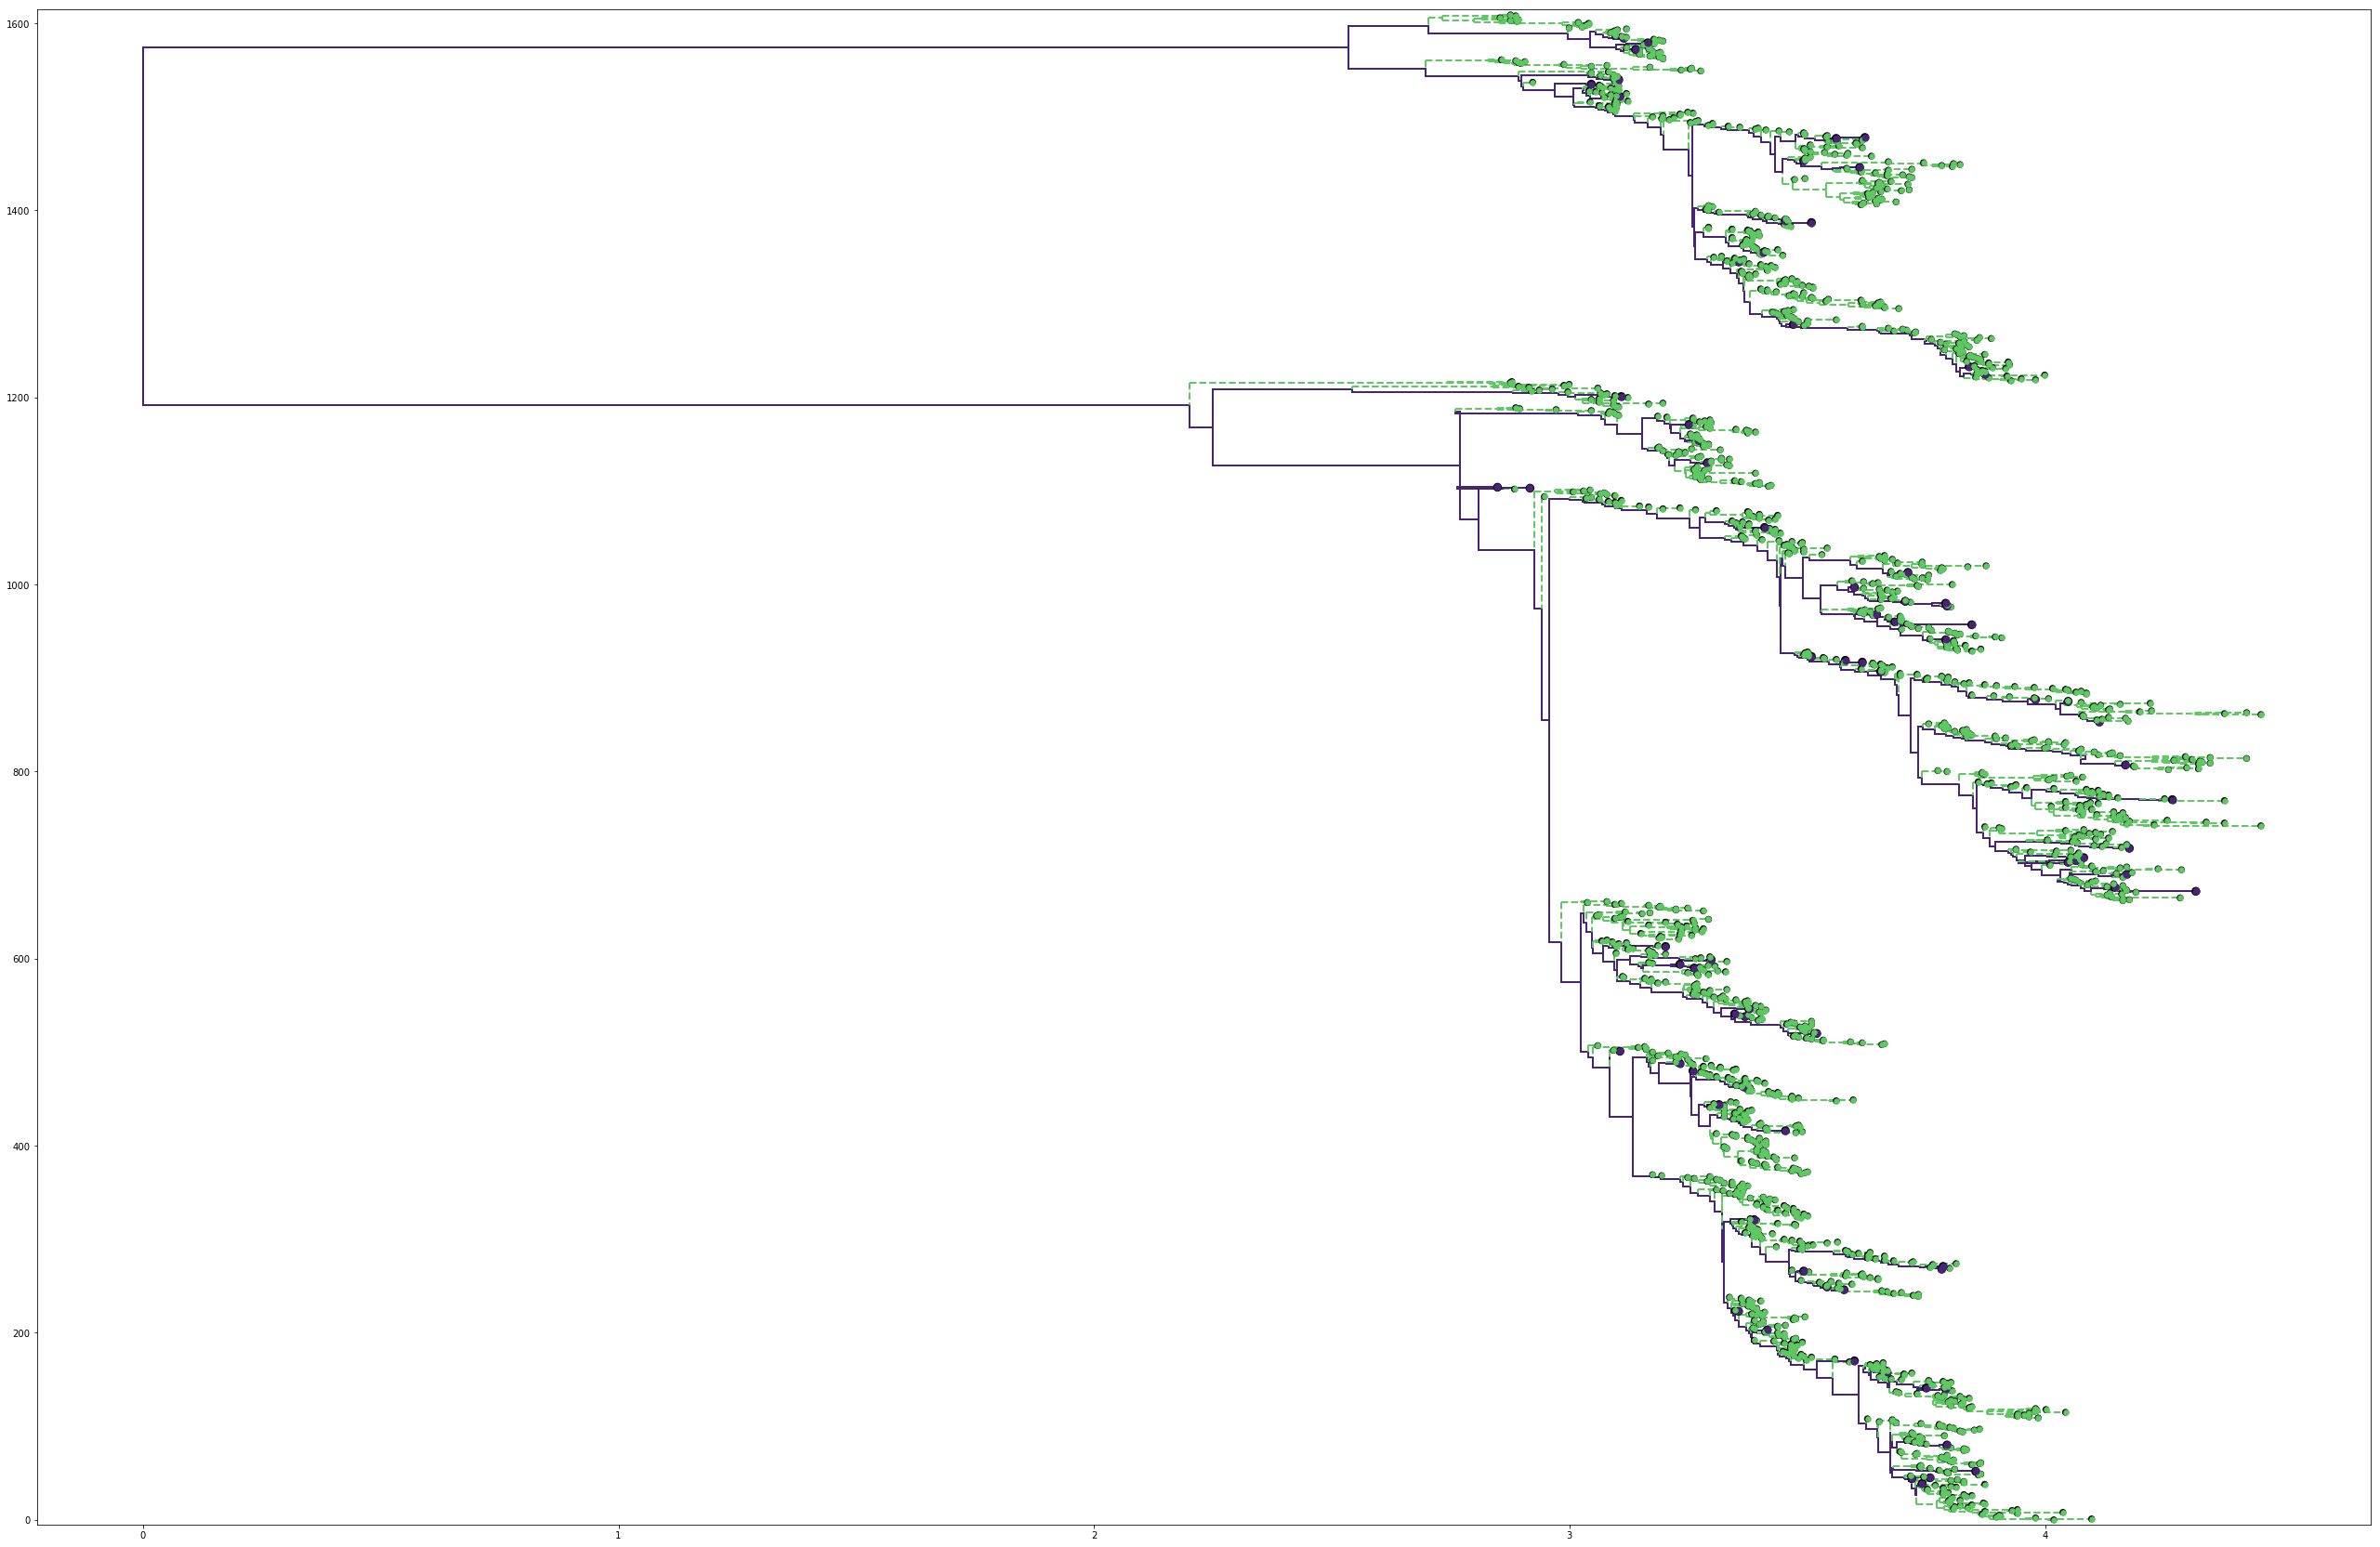

In [5]:
#plotted missing samples
fig,ax = plt.subplots(figsize=(45,30),facecolor='w')
branchWidth=2

cmap = mpl.cm.get_cmap('viridis')
unsamp = cmap(0.75)
samp = cmap(.1)

for k in pruned_dict.get('full_tree').nodes(): ## iterate over objects in tree
    
    # positioning
    y=y_positions.get(k) 
    yp = y_positions.get(k.parent_node)
    if k.edge.rootedge:
        x=0.0
    else:
        x=k.distance_from_root()
    if k.parent_node==None:
        xp=x
    else:
        xp=k.parent_node.distance_from_root()

    # dropped tips, color, lty, size
    c = [unsamp if k.label not in pruned_labs else samp][0]
    lty = ['--' if k.label not in pruned_labs else '-'][0]
    s = [30 if k.label not in pruned_labs else 50][0]
    
    if k.is_leaf(): # if leaf...
        ax.scatter(x,y,s=s,facecolor=c,edgecolor=c,zorder=11) # plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) # plot black circle underneath
    ax.plot([xp,xp],[y, yp],lw=branchWidth, color=c,ls=lty,zorder=9) #vertical bar plotting
    ax.plot([xp,x], [y,y], lw=branchWidth, color=c, ls=lty, zorder=9) #branch plotting
       
ax.set_ylim(-5, len(pruned_dict.get('full_tree').leaf_nodes()) + 5)

plt.show()

### Pruned Tree

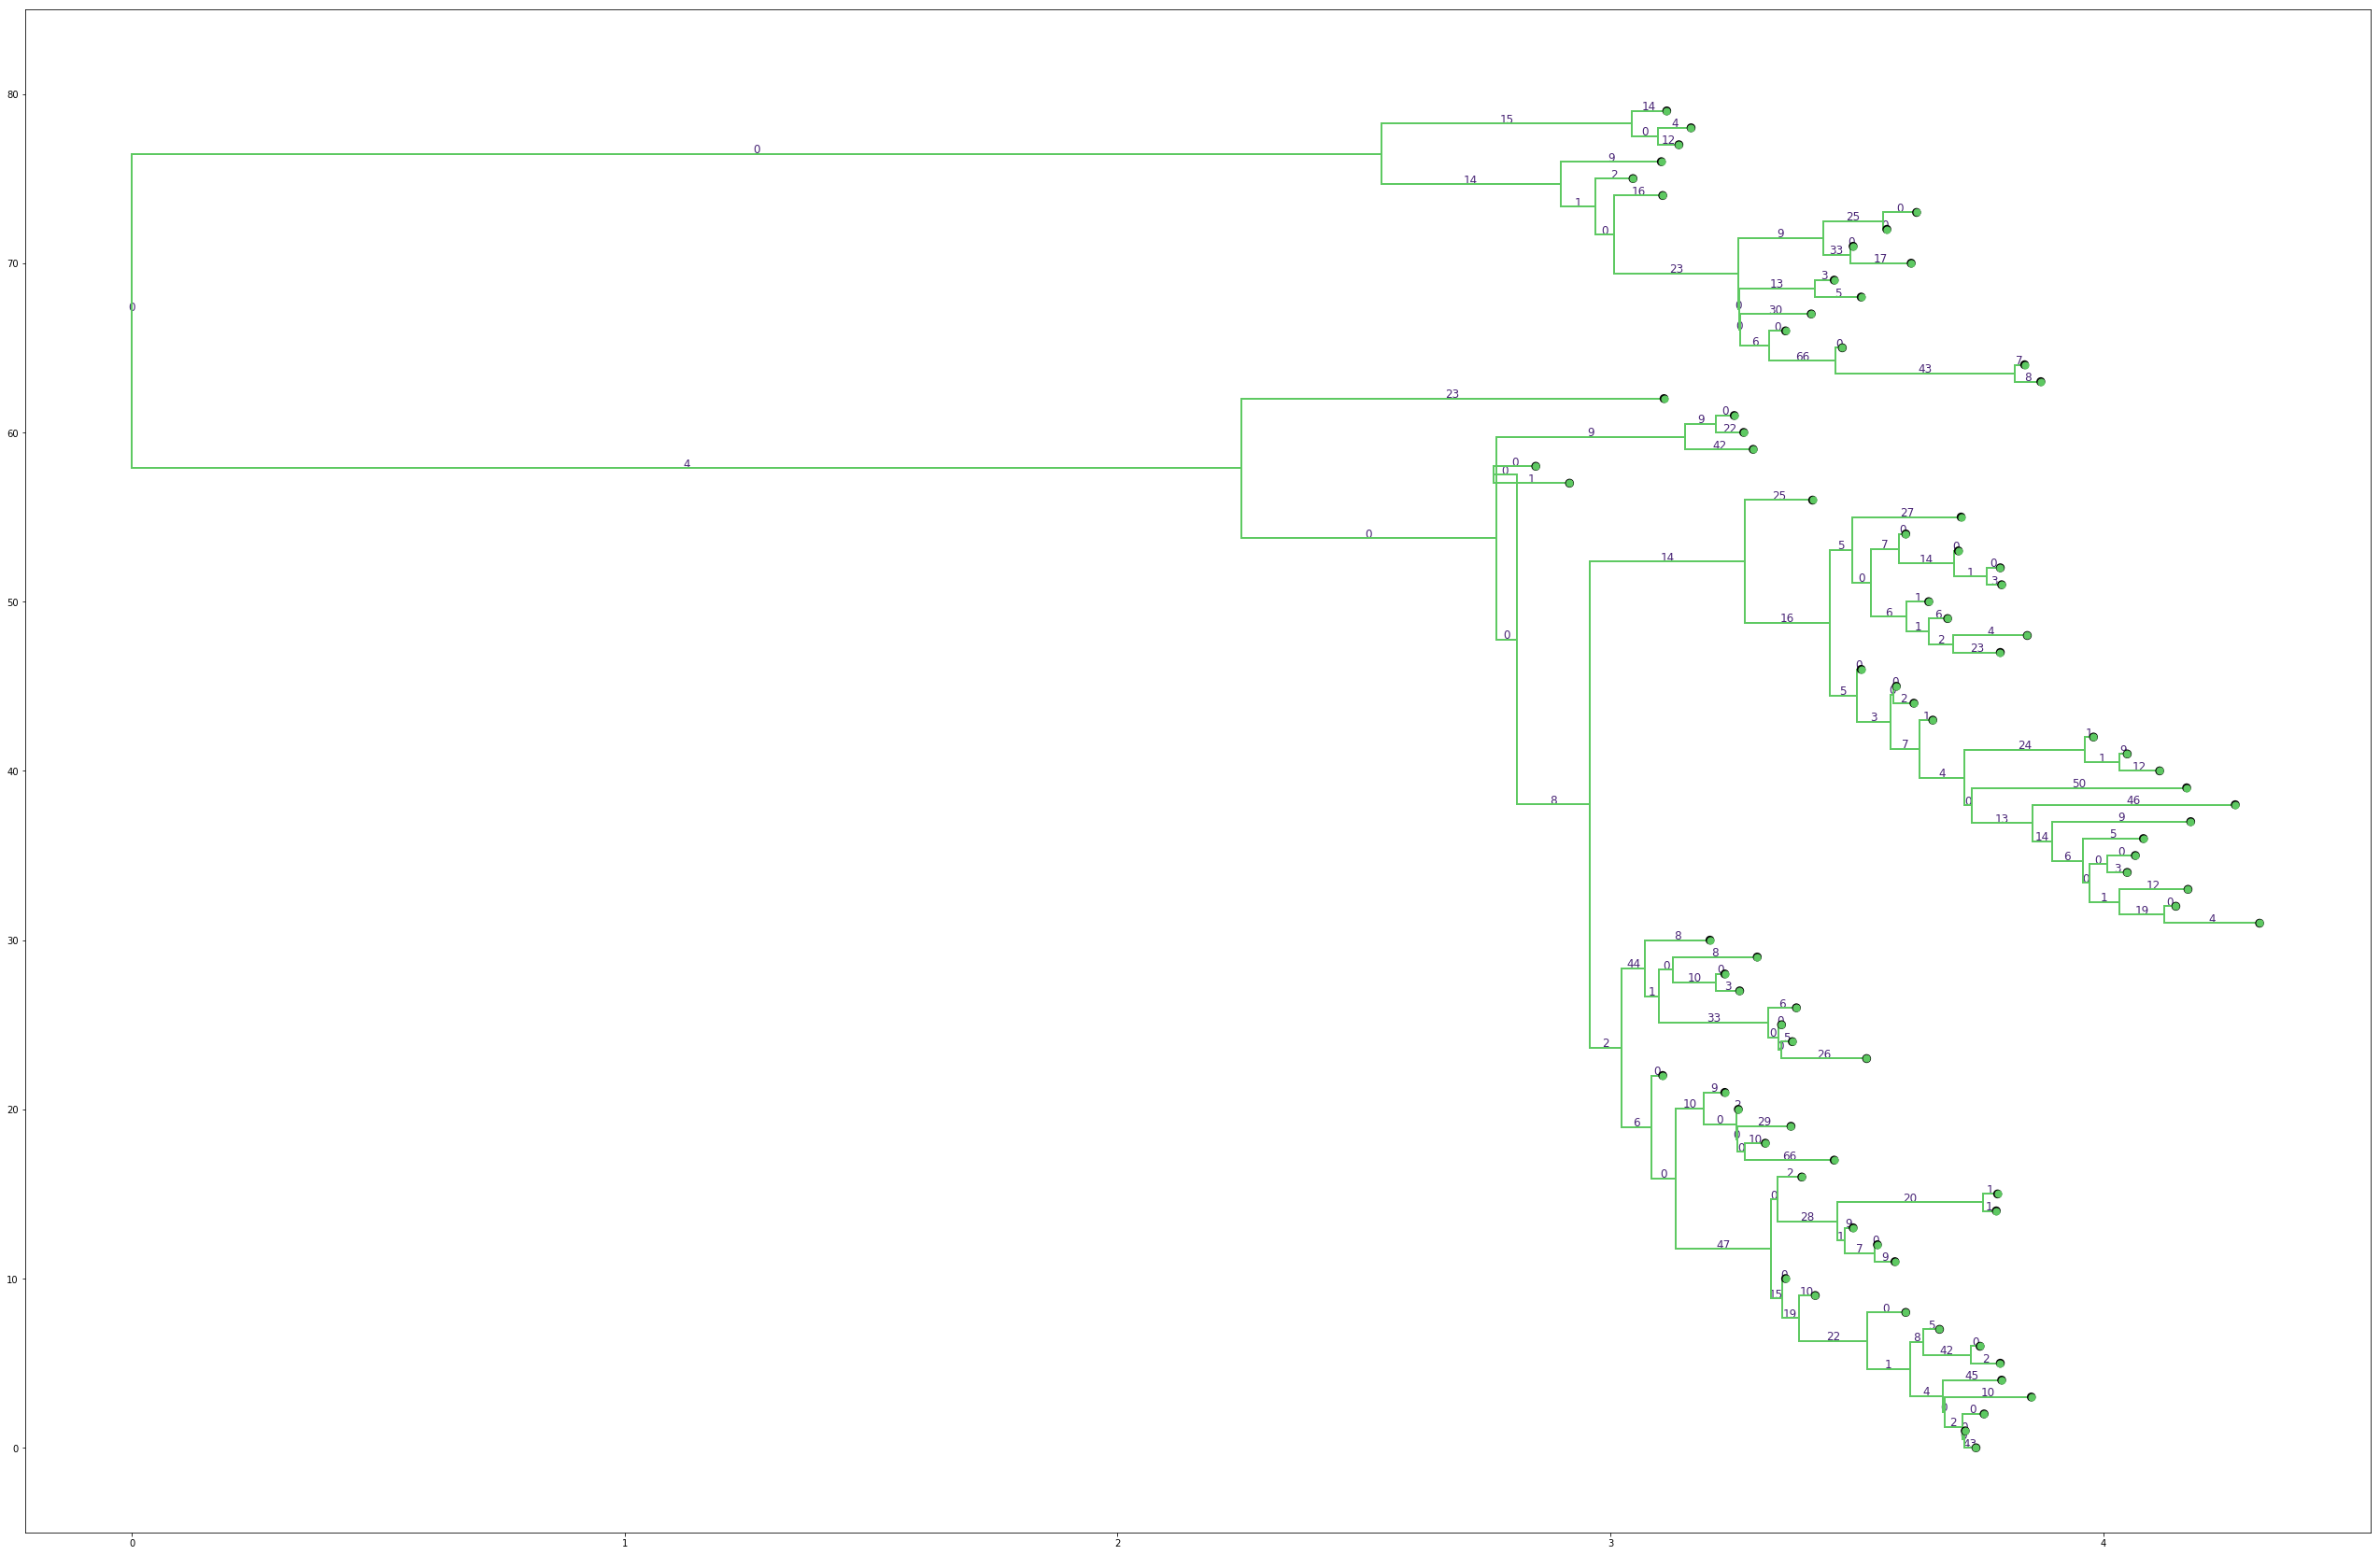

In [6]:
#plotted missing samples
fig,ax = plt.subplots(figsize=(45,30),facecolor='w')
branchWidth=2

cmap = mpl.cm.get_cmap('viridis')
unsamp = cmap(0.75)

for k in pruned_dict.get('pruned_tree').nodes(): ## iterate over objects in tree
    
    # positioning
    y=y_pos.get(k) 

    if k.parent_node==None:
        x=0.0
        xp=x
        yp = y_pos.get(k)
    else:
        yp = y_pos.get(k.parent_node)
        xp=k.parent_node.distance_from_root()
        x=k.distance_from_root()
        
    #distribution of missing samples
    if true_num_unsamp.has_key(k.label):
        dropped = true_num_unsamp.get(k.label)
    else:
        dropped = 0

    if k.is_leaf(): # if leaf...
        ax.scatter(x,y,s=50,facecolor=unsamp,edgecolor=unsamp,zorder=11) # plot circle for every tip
        ax.scatter(x,y,s=50+0.8*50,facecolor='k',edgecolor='none',zorder=10) # plot black circle underneath
    ax.plot([xp,xp],[y, yp],lw=branchWidth, color=unsamp,ls='-',zorder=9) #vertical bar plotting
    ax.plot([xp,x], [y,y], lw=branchWidth, color=unsamp, ls='-', zorder=9) #branch plotting
    
    #labeling number of true missing branches along each edge
    ax.text(x-.5*(x-xp) , y-.1, dropped, va='bottom', ha='center', size=12, color = cmap(.1)) 
       
ax.set_ylim(-5, len(pruned_dict.get('pruned_tree').leaf_nodes()) + 5)

plt.show()

### Pruned Tree with Distribution of Expected and Observed Missing Samples

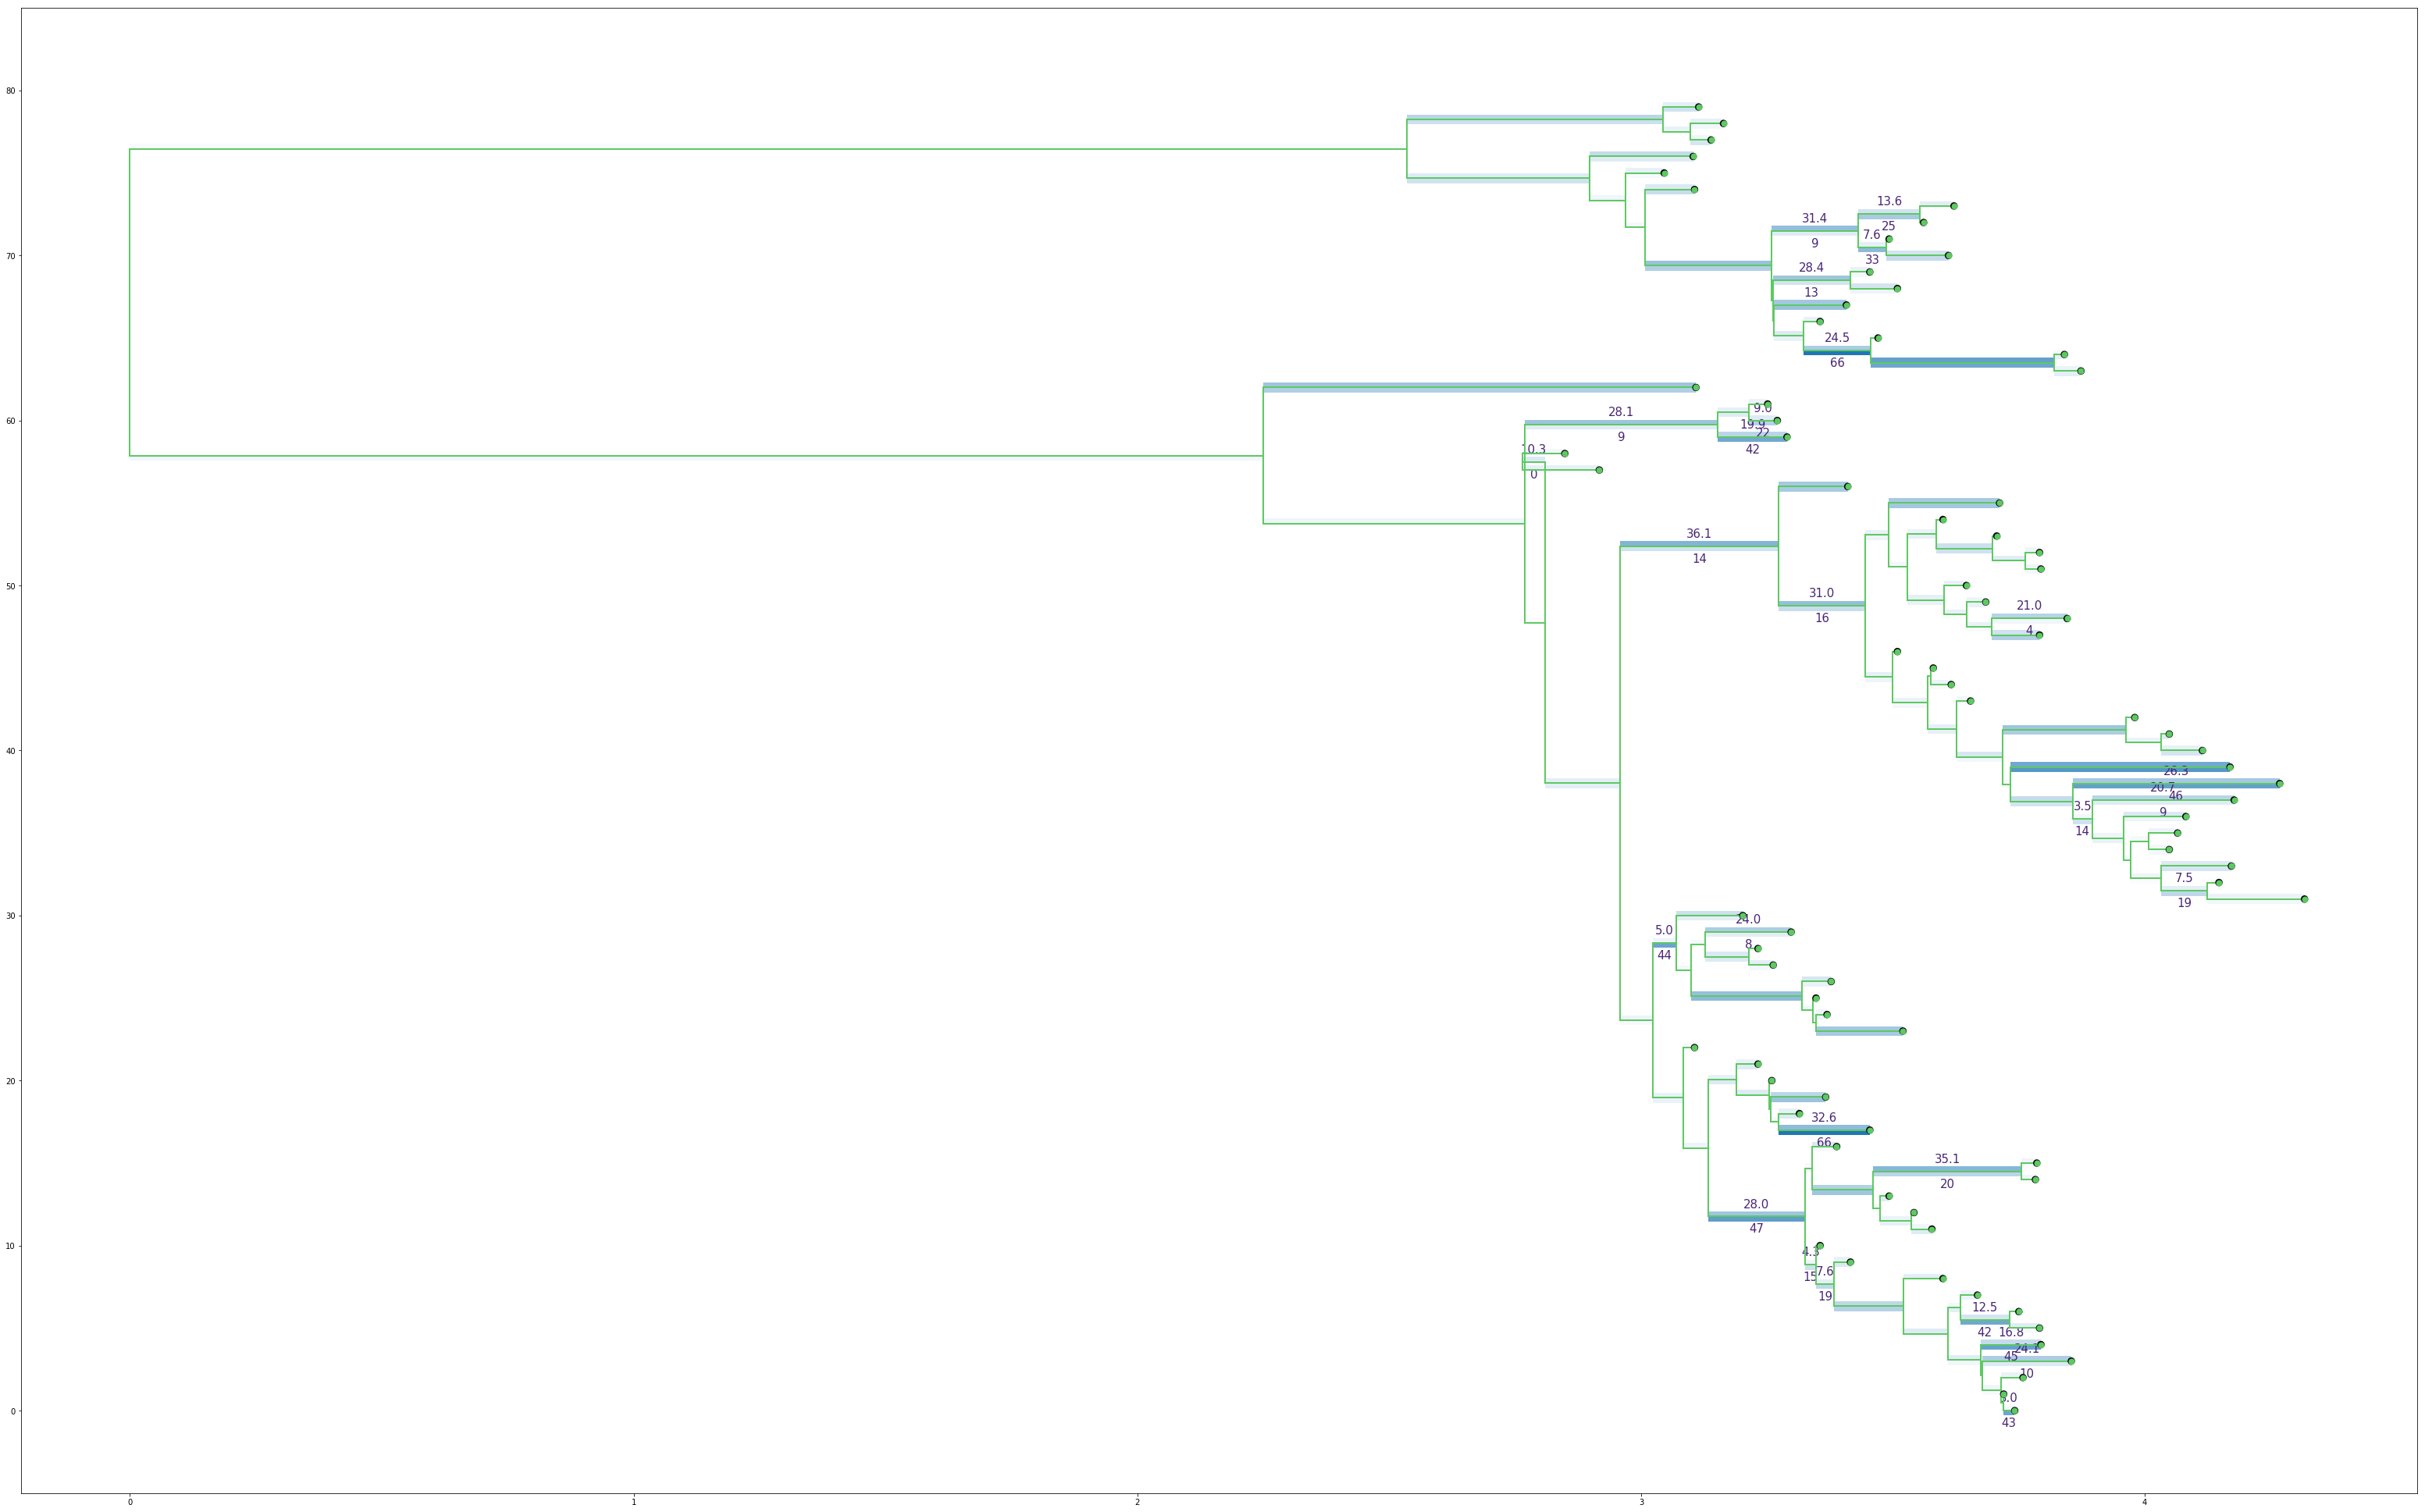

In [7]:
#plotted missing samples
fig,ax = plt.subplots(figsize=(55, 35), facecolor='w')
branchWidth=2

cmap = mpl.cm.get_cmap('viridis')
alphas = []
for index, k in enumerate(pruned_dict.get('pruned_tree').nodes()): ## iterate over objects in tree
    #distribution of missing samples
    if true_num_unsamp.has_key(k.label):
        dropped = true_num_unsamp.get(k.label)
    else:
        dropped = 0
    
    # positioning
    y=y_pos.get(k) 

    if k.parent_node==None:
        x=0.0
        xp=x
        yp = y_pos.get(k)
    else:
        yp = y_pos.get(k.parent_node)
        xp=k.parent_node.distance_from_root()
        x=k.distance_from_root()

    # dropped tips, color, lty, size
    c = cmap(.75)
    lty = '-'
    s = 50
    
    if k.is_leaf(): # if leaf...
        ax.scatter(x,y,s=s,facecolor=c,edgecolor=c,zorder=11) # plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) # plot black circle underneath
    ax.plot([xp,xp],[y, yp],lw=branchWidth, color=c,ls=lty,zorder=9) #vertical bar plotting
    ax.plot([xp,x], [y,y], lw=branchWidth, color=c, ls=lty, zorder=9) #branch plotting
    
    #expected distribution of missing data
    edge_prb = exp[:,index]
    alph = sum(edge_prb)/len(edge_prb)*1530.0
    alphas.append(alph)
    ax.add_patch(mpl.patches.Rectangle((xp,y), (x-xp), .3, alpha = alph/66.0)) #predicted proportion of dropped
    ax.add_patch(mpl.patches.Rectangle((xp,y-.3), (x-xp), .3, alpha = int(dropped)/66.0)) #actual dropped

    #labeling
    #ax.text(x - .5*(x-xp), y, "| "*dropped, va = 'center', ha= 'center', size=9, color = cmap(.1))
    if abs(int(dropped) - alph) > 10:
        ax.text(x-1.0/2*(x-xp) , y-.4, dropped, va='top', ha='center', size=15, color = cmap(.1)) #actual dropped
        ax.text(x-1.0/2*(x-xp) , y+.4, str(round(alph,1)), va='bottom', ha='center', size=15, color = cmap(.1)) #predicted dropped
ax.set_ylim(-5, len(pruned_dict.get('pruned_tree').leaf_nodes()) + 5)

plt.show()

### Proportion of Tips Expected Under Each Internal Node - Full Tree

In [8]:
node_probs = calculate_cumulative_node_prob(ebov, 1)

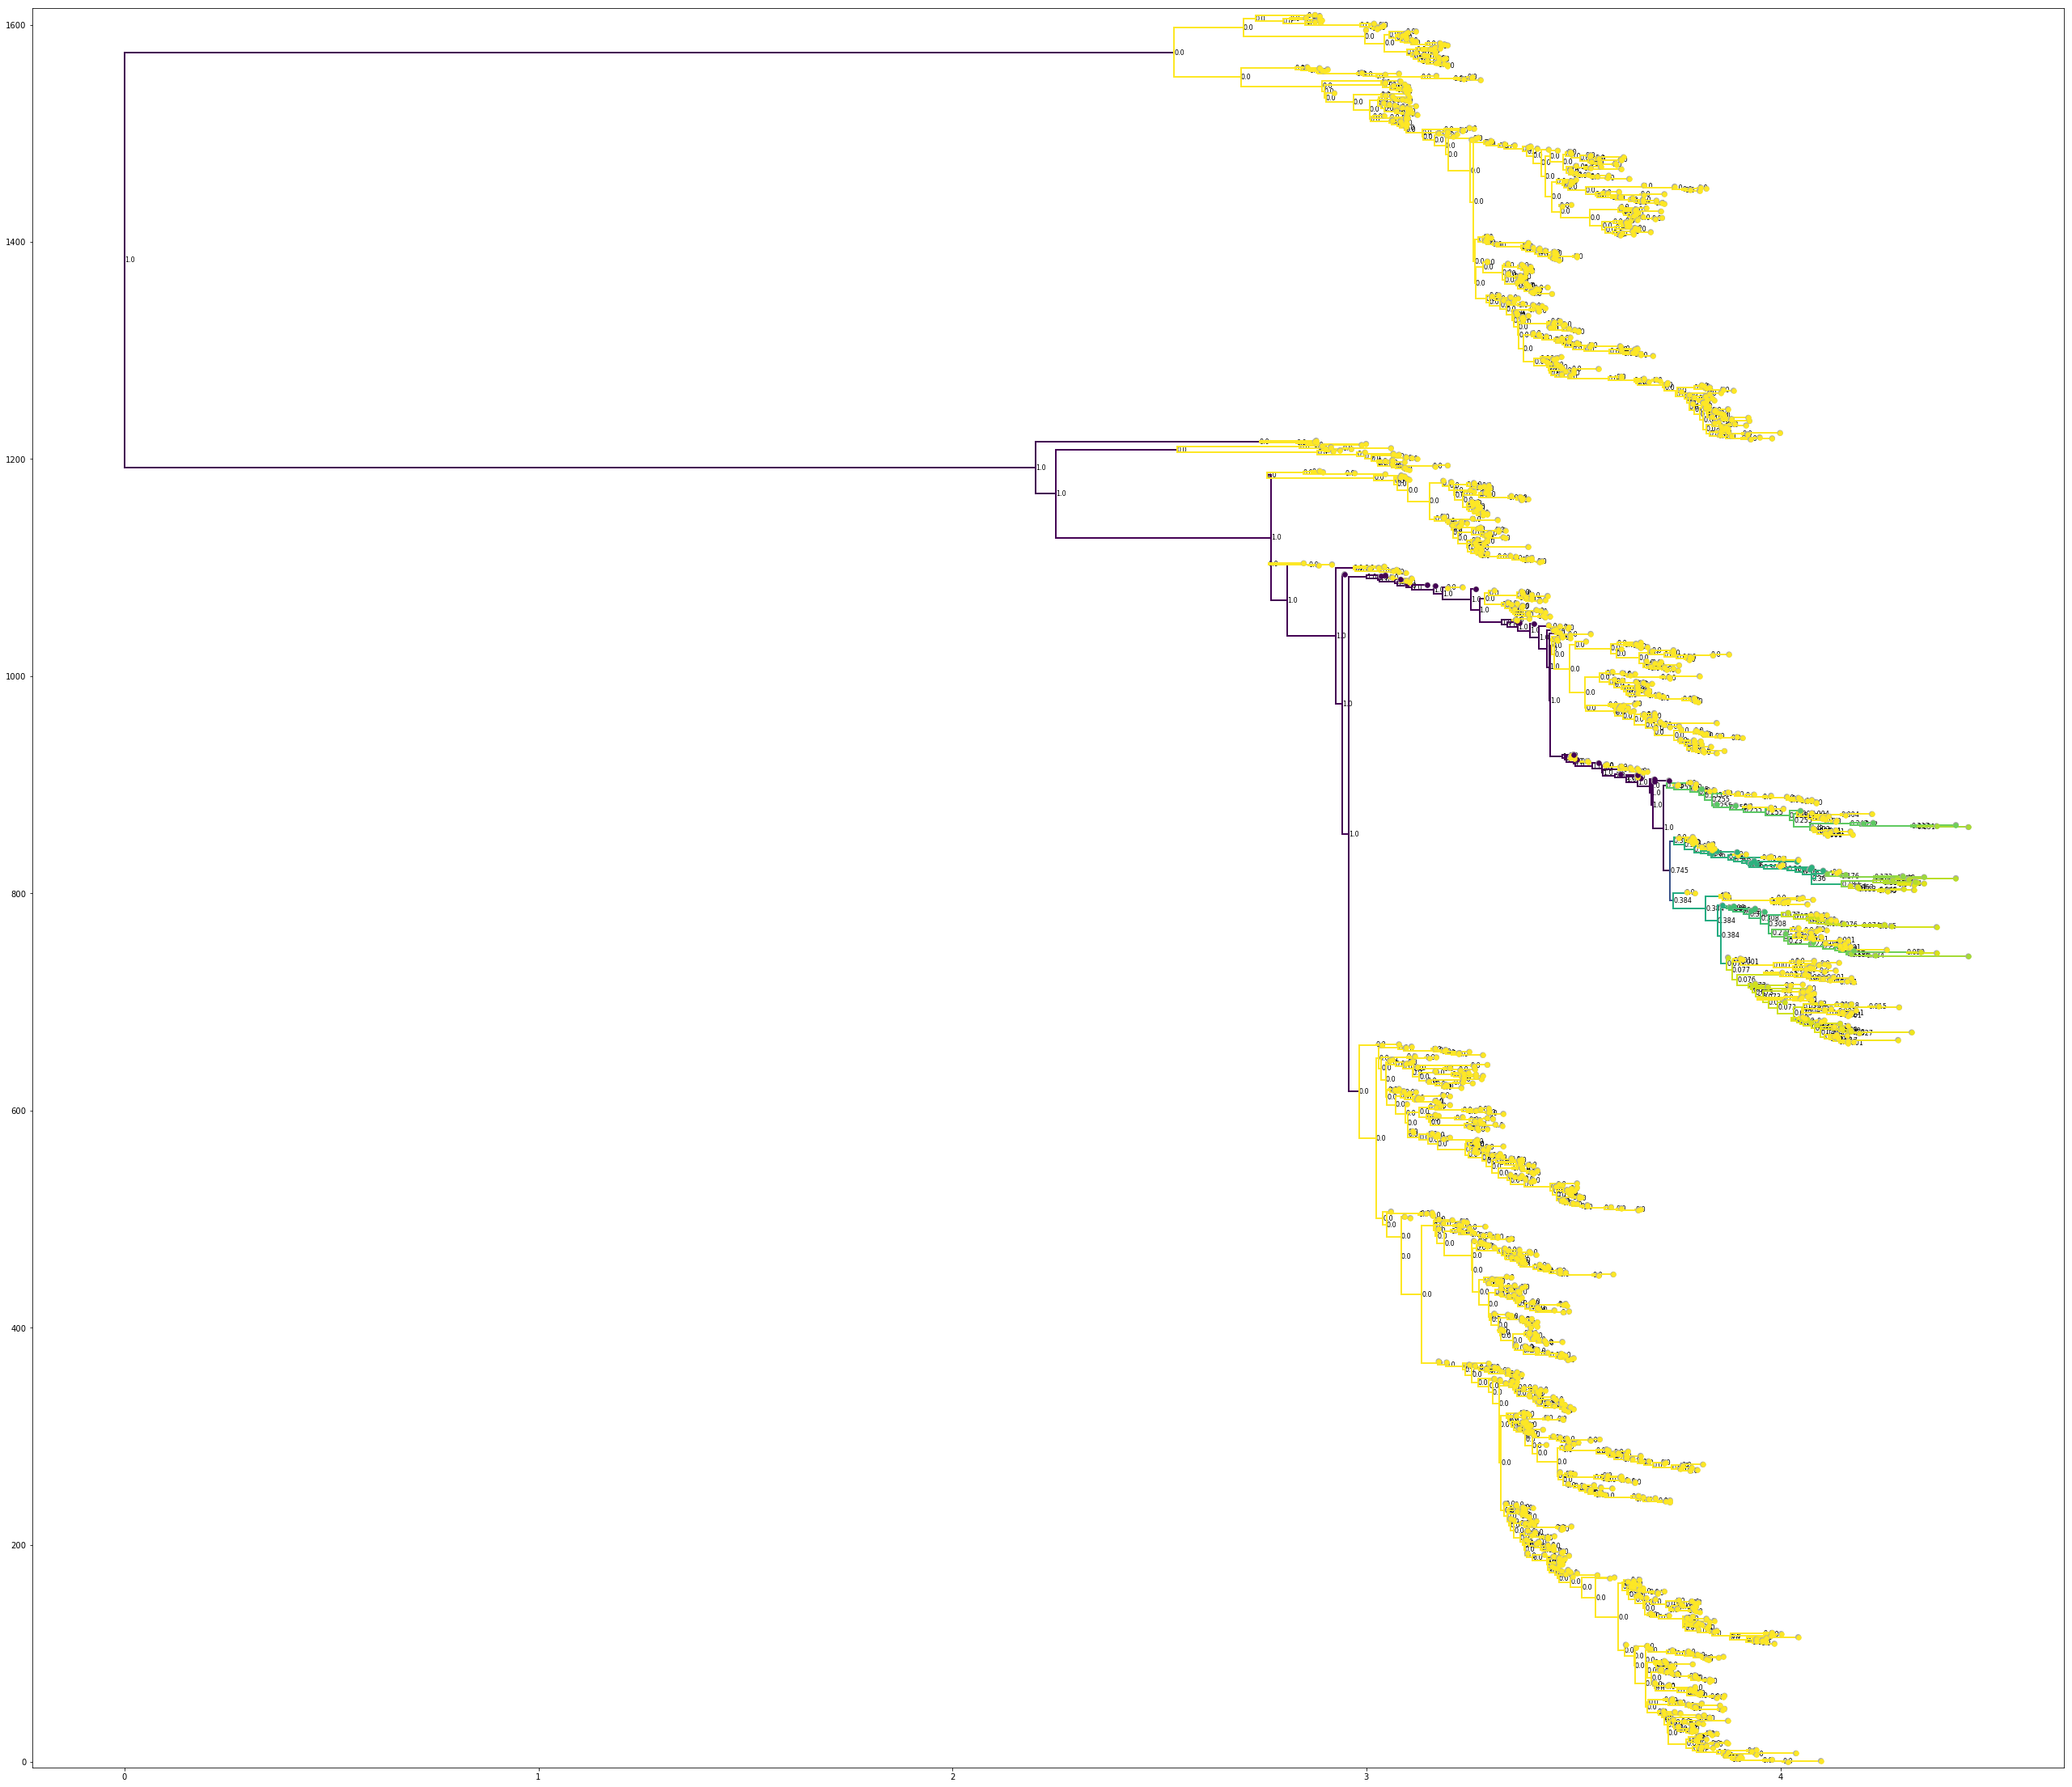

In [9]:
fig,ax = plt.subplots(figsize=(45,40),facecolor='w')
branchWidth=2
cmap=mpl.cm.viridis

for k in pruned_dict.get('full_tree').nodes(): ## iterate over objects in tree
    
    # positioning
    y=y_positions.get(k) 
    if k.edge.rootedge:
        x=0.0
    else:
        x=k.distance_from_root()
    #if k.parent_node==None:
    #    xp=x
    #else:
    #    xp=k.parent_node.distance_from_root()

    # dropped tips, color, lty, size
    if node_probs.get(k) != None:
        c = cmap(1-(node_probs.get(k)))
        txt = round(node_probs.get(k), 3)
    else:
        c = cmap(1-(node_probs.get(k.parent_node)))
        txt = ""

    lty = "-"
    s = 30
    
    if k.is_leaf(): # if leaf...
        ax.scatter(x,y,s=s,facecolor=c,edgecolor=c,zorder=11) # plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='darkgrey',edgecolor='none',zorder=10) # plot black circle underneath
        
    else:
        yc1 = y_positions.get(k.child_nodes()[0])
        yc2 = y_positions.get(k.child_nodes()[-1])
        xc1 = k.child_nodes()[0].distance_from_root()
        xc2 = k.child_nodes()[-1].distance_from_root()
    
        ax.plot([x,x],[yc1, yc2],lw=branchWidth, color=c,ls=lty,zorder=9) #vertical bar plotting
        ax.plot([xc1,x], [yc1,yc1], lw=branchWidth, color=c, ls=lty, zorder=9) #plot top child edge
        ax.plot([xc2,x], [yc2,yc2], lw=branchWidth, color=c, ls=lty, zorder=9) #plot bottom child edge
    
    #labeling
    ax.text(x, y, txt, va = 'center', ha= 'left', size=8, color = 'k')

ax.set_ylim(-5, len(pruned_dict.get('full_tree').leaf_nodes()) + 5)
plt.show()

### Z-Scores

In [10]:
zs = node_zscores(node_probs, ebov)

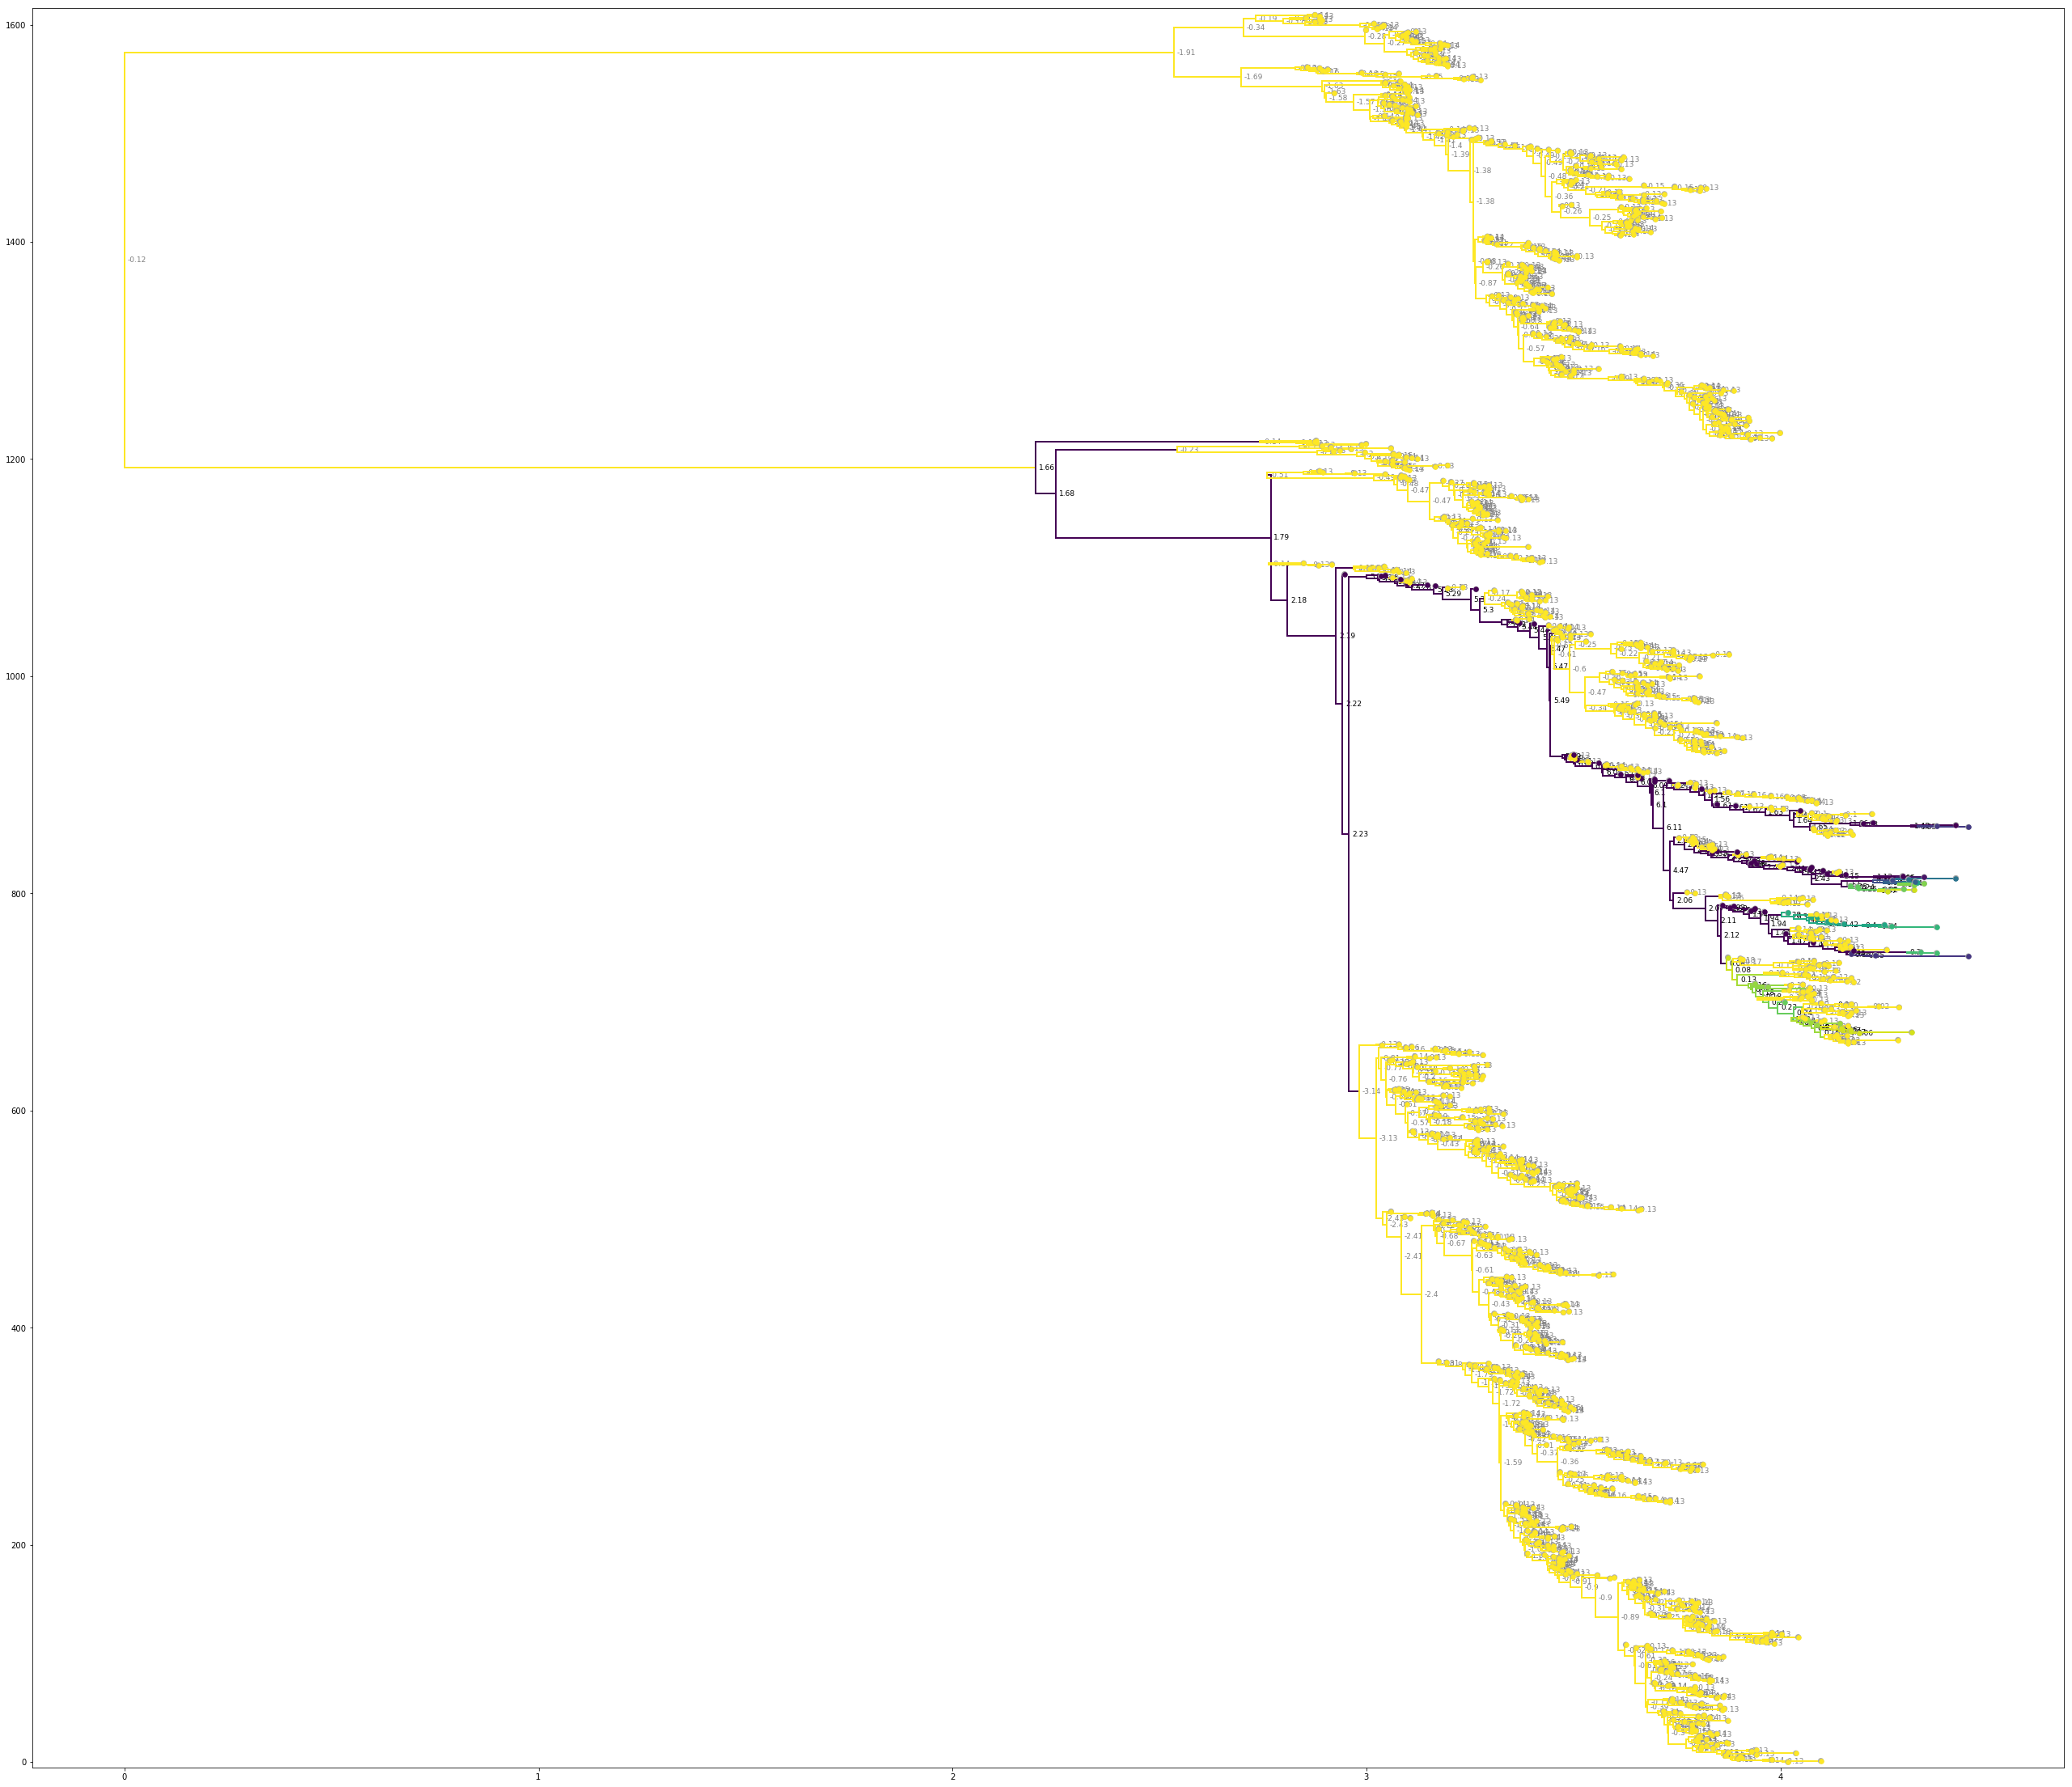

In [11]:
fig,ax = plt.subplots(figsize=(45,40),facecolor='w')
branchWidth=2
cmap=mpl.cm.viridis

for k in pruned_dict.get('full_tree').nodes(): ## iterate over objects in tree
    
    # positioning
    y=y_positions.get(k) 
    if k.edge.rootedge:
        x=0.0
    else:
        x=k.distance_from_root()
    #if k.parent_node==None:
    #    xp=x
    #else:
    #    xp=k.parent_node.distance_from_root()

    # dropped tips, color, lty, size
    if node_probs.get(k) != None:
        c = cmap(1-(zs.get(k)))
        txt = round(zs.get(k), 2)
        if zs.get(k) > 0:
            col = "k"
        else:
            col = "grey"
    else:
        c = cmap(1-(zs.get(k.parent_node)))
        txt = ""
    #c="r"
    lty = "-"
    s = 30
    
    if k.is_leaf(): # if leaf...
        ax.scatter(x,y,s=s,facecolor=c,edgecolor=c,zorder=11) # plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='darkgrey',edgecolor='none',zorder=10) # plot black circle underneath
        
    else:
        yc1 = y_positions.get(k.child_nodes()[0])
        yc2 = y_positions.get(k.child_nodes()[-1])
        xc1 = k.child_nodes()[0].distance_from_root()
        xc2 = k.child_nodes()[-1].distance_from_root()
    
        ax.plot([x,x],[yc1, yc2],lw=branchWidth, color=c,ls=lty,zorder=9) #vertical bar plotting
        ax.plot([xc1,x], [yc1,yc1], lw=branchWidth, color=c, ls=lty, zorder=9) #plot top child edge
        ax.plot([xc2,x], [yc2,yc2], lw=branchWidth, color=c, ls=lty, zorder=9) #plot bottom child edge
    
    #labeling
    ax.text(x + .007, y, txt, va = 'center', ha= 'left', size=9, color = col)

ax.set_ylim(-5, len(pruned_dict.get('full_tree').leaf_nodes()) + 5)
plt.show()

### Proportion of Tips Expected Under Each Internal Node - Remaining Tree

In [12]:
node_probs2 = calculate_cumulative_node_prob(pruned_dict.get('pruned_tree'), 1)

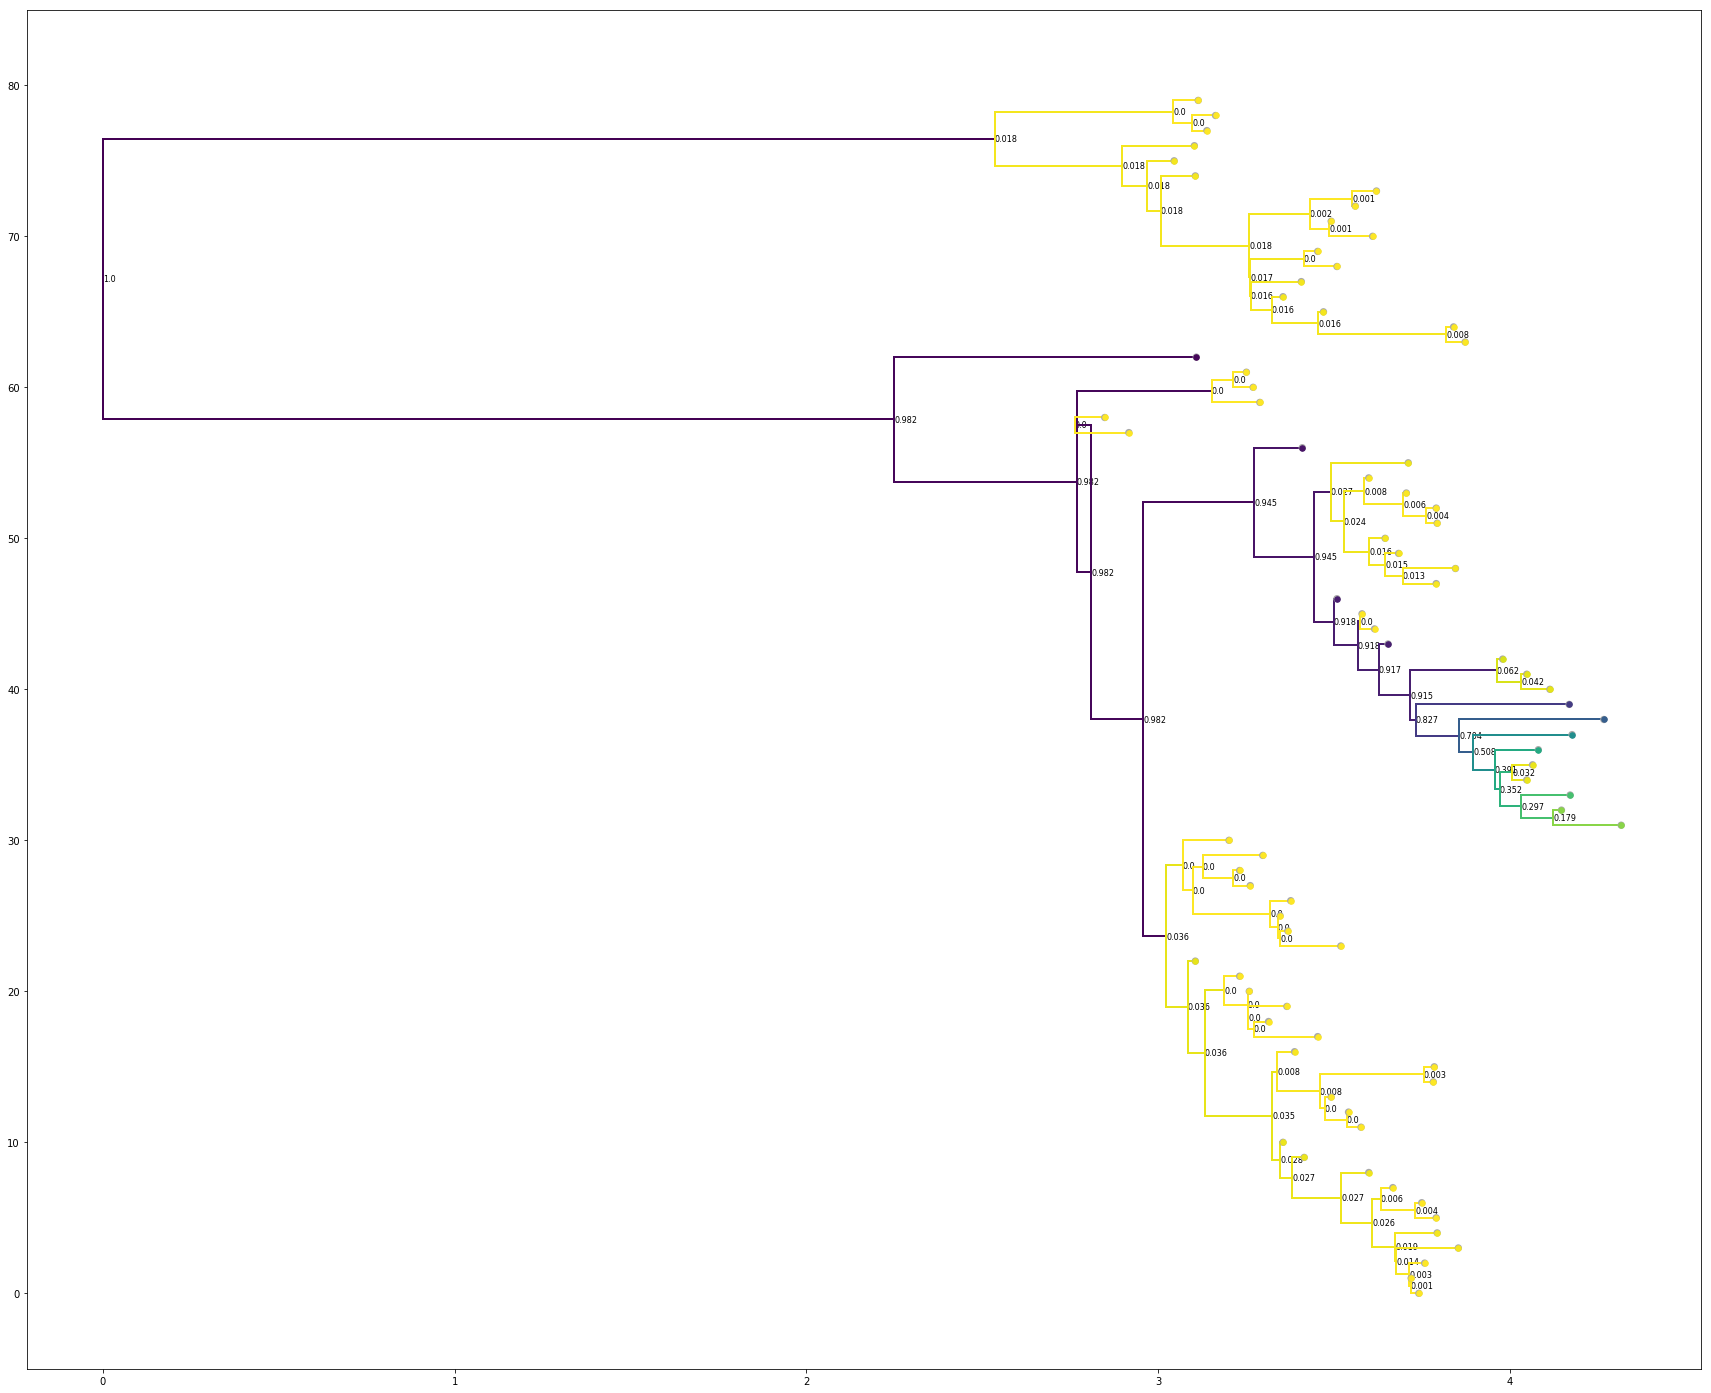

In [13]:
fig,ax = plt.subplots(figsize=(30,25),facecolor='w')
branchWidth=2
cmap=mpl.cm.viridis

for k in pruned_dict.get('pruned_tree').nodes(): ## iterate over objects in tree
    
    # positioning
    y=y_pos.get(k) 
    if k.edge.rootedge:
        x=0.0
    else:
        x=k.distance_from_root()

    # dropped tips, color, lty, size
    if node_probs2.get(k) != None:
        c = cmap(1-(node_probs2.get(k)))
        txt = round(node_probs2.get(k), 3)
    else:
        c = cmap(1-(node_probs2.get(k.parent_node)))
        txt = ""

    lty = "-"
    s = 30
    
    if k.is_leaf(): # if leaf...
        ax.scatter(x,y,s=s,facecolor=c,edgecolor=c,zorder=11) # plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='darkgrey',edgecolor='none',zorder=10) # plot black circle underneath
        
    else:
        yc1 = y_pos.get(k.child_nodes()[0])
        yc2 = y_pos.get(k.child_nodes()[-1])
        xc1 = k.child_nodes()[0].distance_from_root()
        xc2 = k.child_nodes()[-1].distance_from_root()
    
        ax.plot([x,x],[yc1, yc2],lw=branchWidth, color=c,ls=lty,zorder=9) #vertical bar plotting
        ax.plot([xc1,x], [yc1,yc1], lw=branchWidth, color=c, ls=lty, zorder=9) #plot top child edge
        ax.plot([xc2,x], [yc2,yc2], lw=branchWidth, color=c, ls=lty, zorder=9) #plot bottom child edge
    
    #labeling
    ax.text(x, y, txt, va = 'center', ha= 'left', size=8, color = 'k')

ax.set_ylim(-5, len(pruned_dict.get('pruned_tree').leaf_nodes()) + 5)
plt.show()

### Z-Scores of Pruned Tree

In [14]:
zs2 = node_zscores(node_probs2, pruned_dict.get('pruned_tree'))

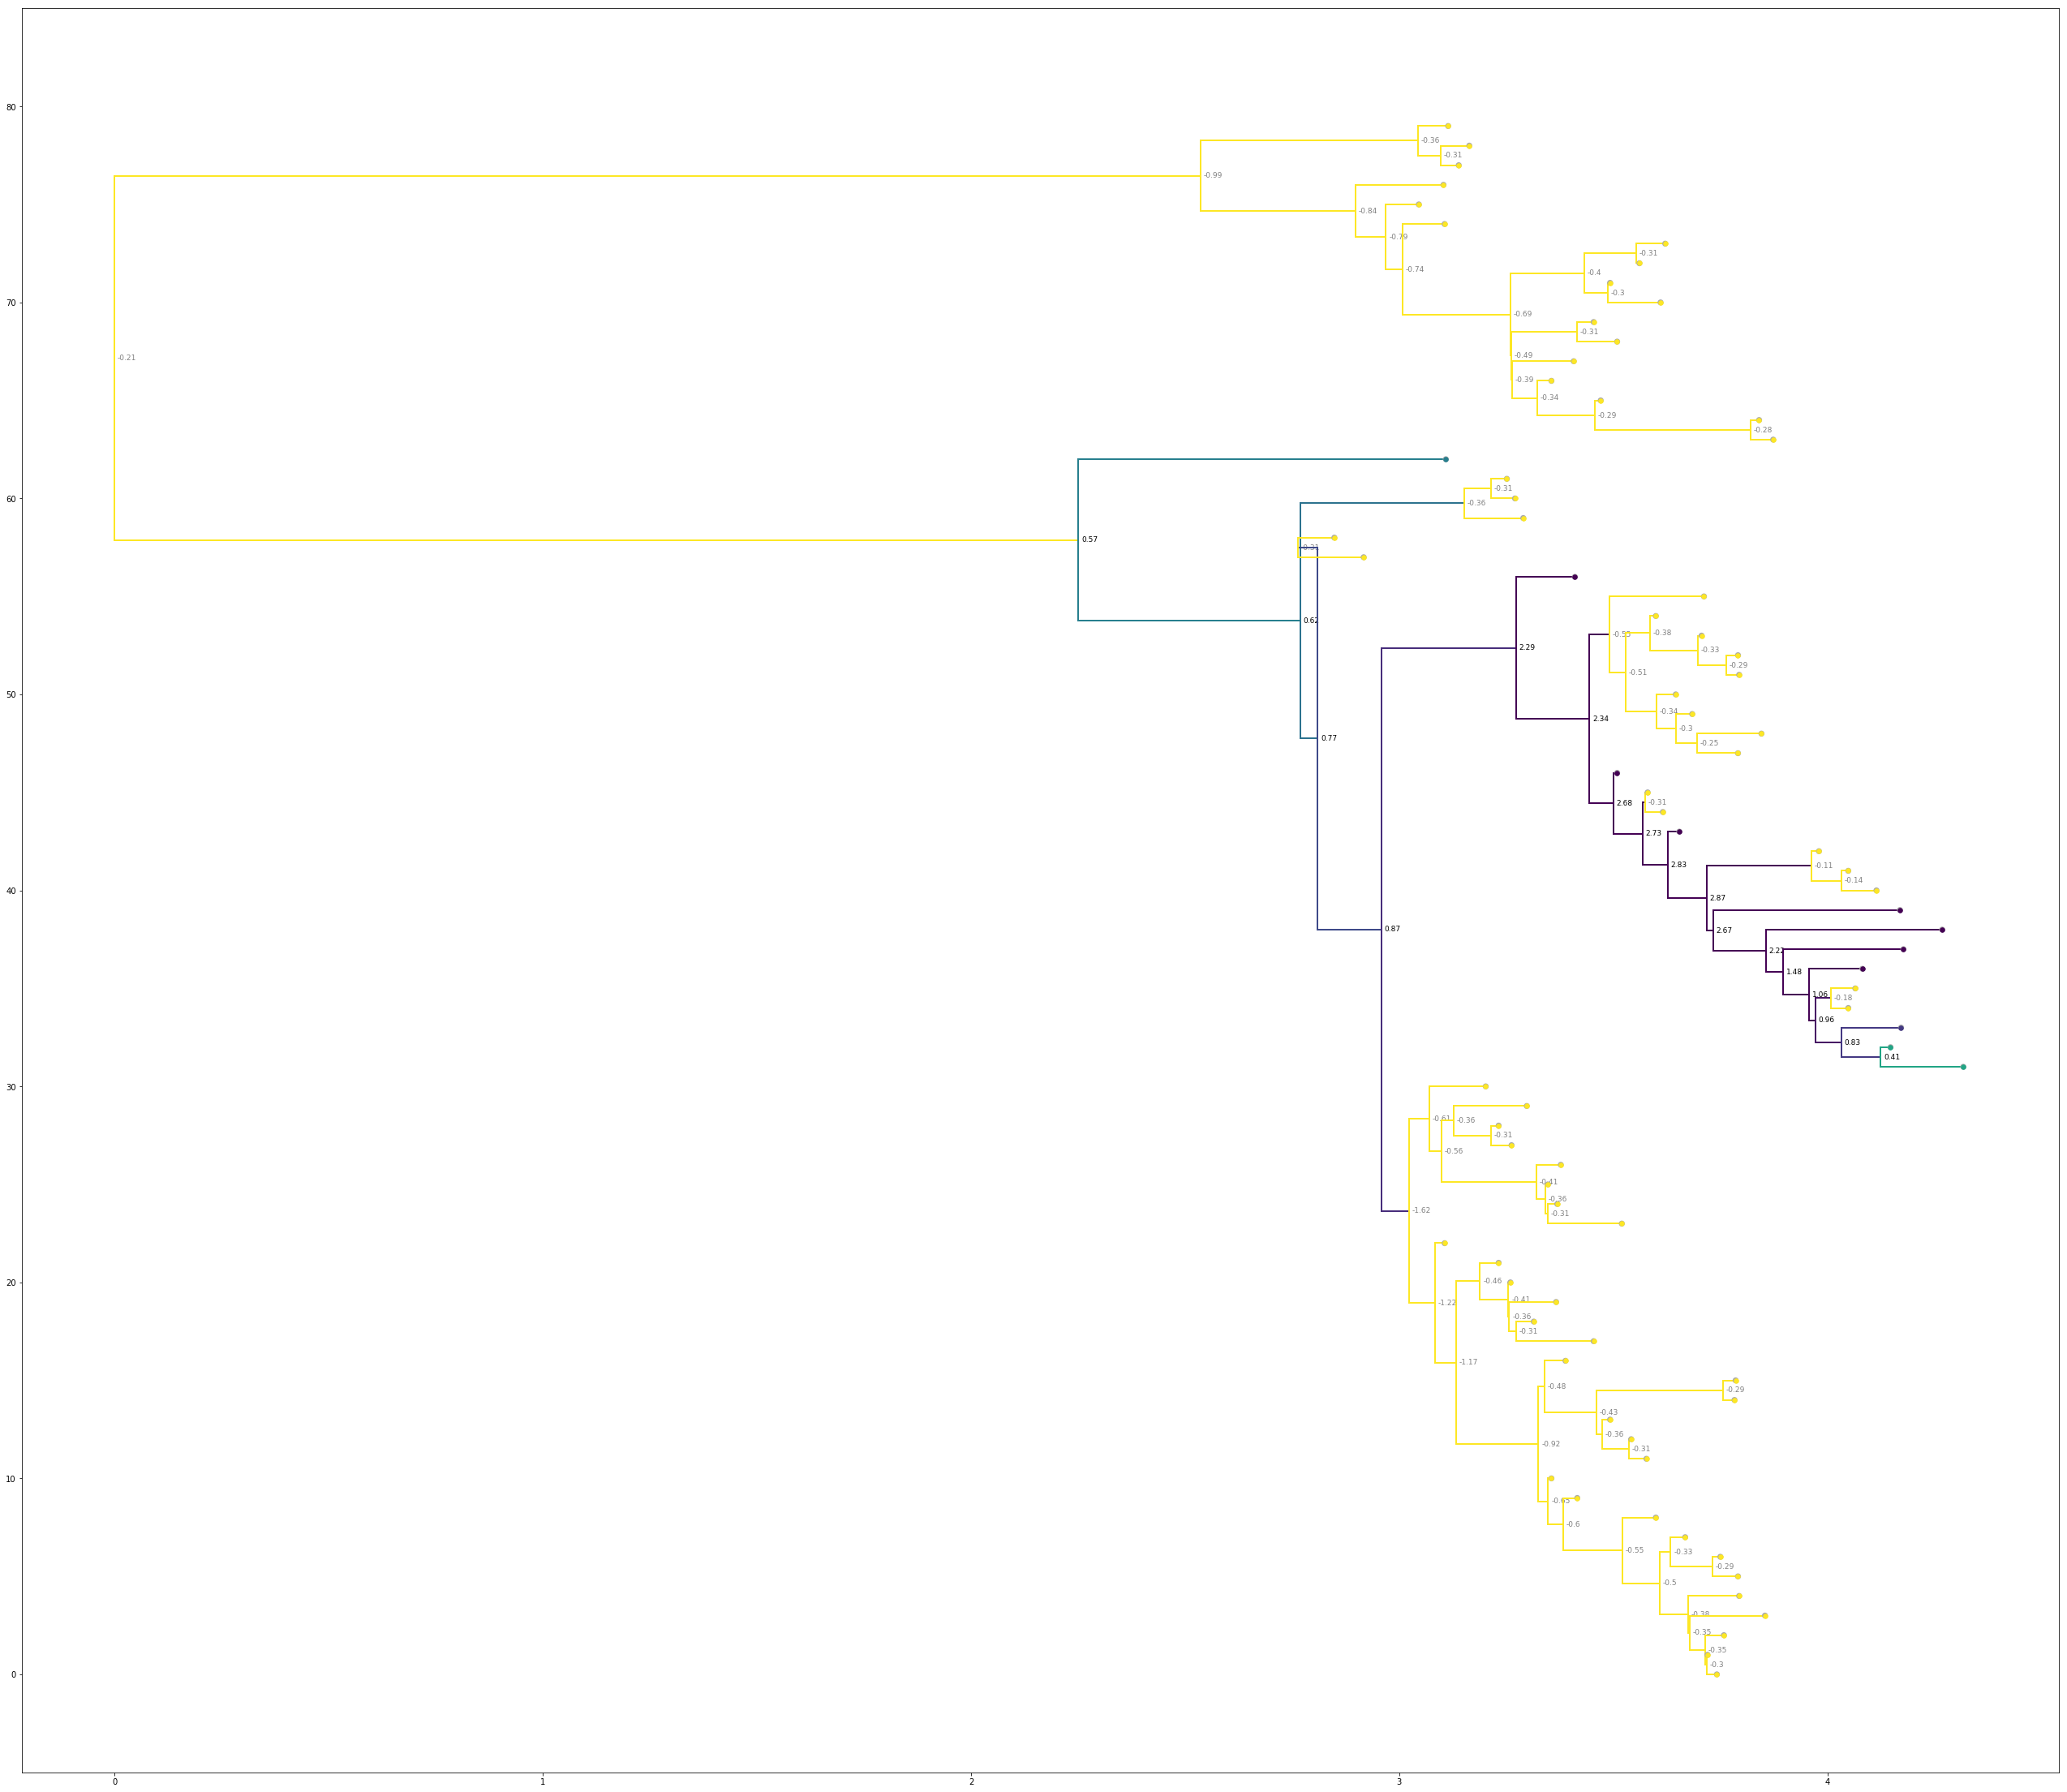

In [15]:
fig,ax = plt.subplots(figsize=(45,40),facecolor='w')
branchWidth=2
cmap=mpl.cm.viridis

for k in pruned_dict.get('pruned_tree').nodes(): ## iterate over objects in tree
    
    # positioning
    y=y_pos.get(k) 
    if k.edge.rootedge:
        x=0.0
    else:
        x=k.distance_from_root()

    # dropped tips, color, lty, size
    if node_probs2.get(k) != None:
        c = cmap(1-(zs2.get(k)))
        txt = round(zs2.get(k), 2)
        if zs2.get(k) > 0:
            col = "k"
        else:
            col = "grey"
    else:
        c = cmap(1-(zs2.get(k.parent_node)))
        txt = ""
    #c="r"
    
    lty = "-"
    s = 30
    
    if k.is_leaf(): # if leaf...
        ax.scatter(x,y,s=s,facecolor=c,edgecolor=c,zorder=11) # plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='darkgrey',edgecolor='none',zorder=10) # plot black circle underneath
        
    else:
        yc1 = y_pos.get(k.child_nodes()[0])
        yc2 = y_pos.get(k.child_nodes()[-1])
        xc1 = k.child_nodes()[0].distance_from_root()
        xc2 = k.child_nodes()[-1].distance_from_root()
    
        ax.plot([x,x],[yc1, yc2],lw=branchWidth, color=c,ls=lty,zorder=9) #vertical bar plotting
        ax.plot([xc1,x], [yc1,yc1], lw=branchWidth, color=c, ls=lty, zorder=9) #plot top child edge
        ax.plot([xc2,x], [yc2,yc2], lw=branchWidth, color=c, ls=lty, zorder=9) #plot bottom child edge
    
    #labeling
    ax.text(x + .007, y, txt, va = 'center', ha= 'left', size=9, color = col)

ax.set_ylim(-5, len(pruned_dict.get('pruned_tree').leaf_nodes()) + 5)
plt.show()

### Node Impurity: Cross-Entropy

In [16]:
total_entropy = 0

for row_o, row_e in zip(obs, exp):
    p_mk = list(row_e)[list(row_o).index(1.0)]
    ent =  p_mk*math.log(p_mk)
    total_entropy += -1*ent
total_entropy

211.6383359484538

In [17]:
null_entropy = -1*(1.0/(obs.shape[1]))*math.log(1.0/(obs.shape[1]))*obs.shape[0]
null_entropy

48.77624798362864

### Variance of Expected Data Distribution

In [22]:
rd.seed(10)
num_runs = 100
edg = len(pruned_dict.get('pruned_tree').edges())
full_counts = np.zeros((num_runs, edg))

for run in range(num_runs):
    for row in exp:
        distr = stats.rv_discrete(values = (range(len(row)), list(row)))
        rv = distr.rvs(size=1)
        full_counts[run][int(rv)] += 1

In [23]:
#grab the middle 95 percentiles of data for each branch
pct_025 = np.percentile(full_counts, 2.5, axis = 0)
pct_975 = np.percentile(full_counts, 97.5, axis=0)

### Observed versus Expected Sum Attachments

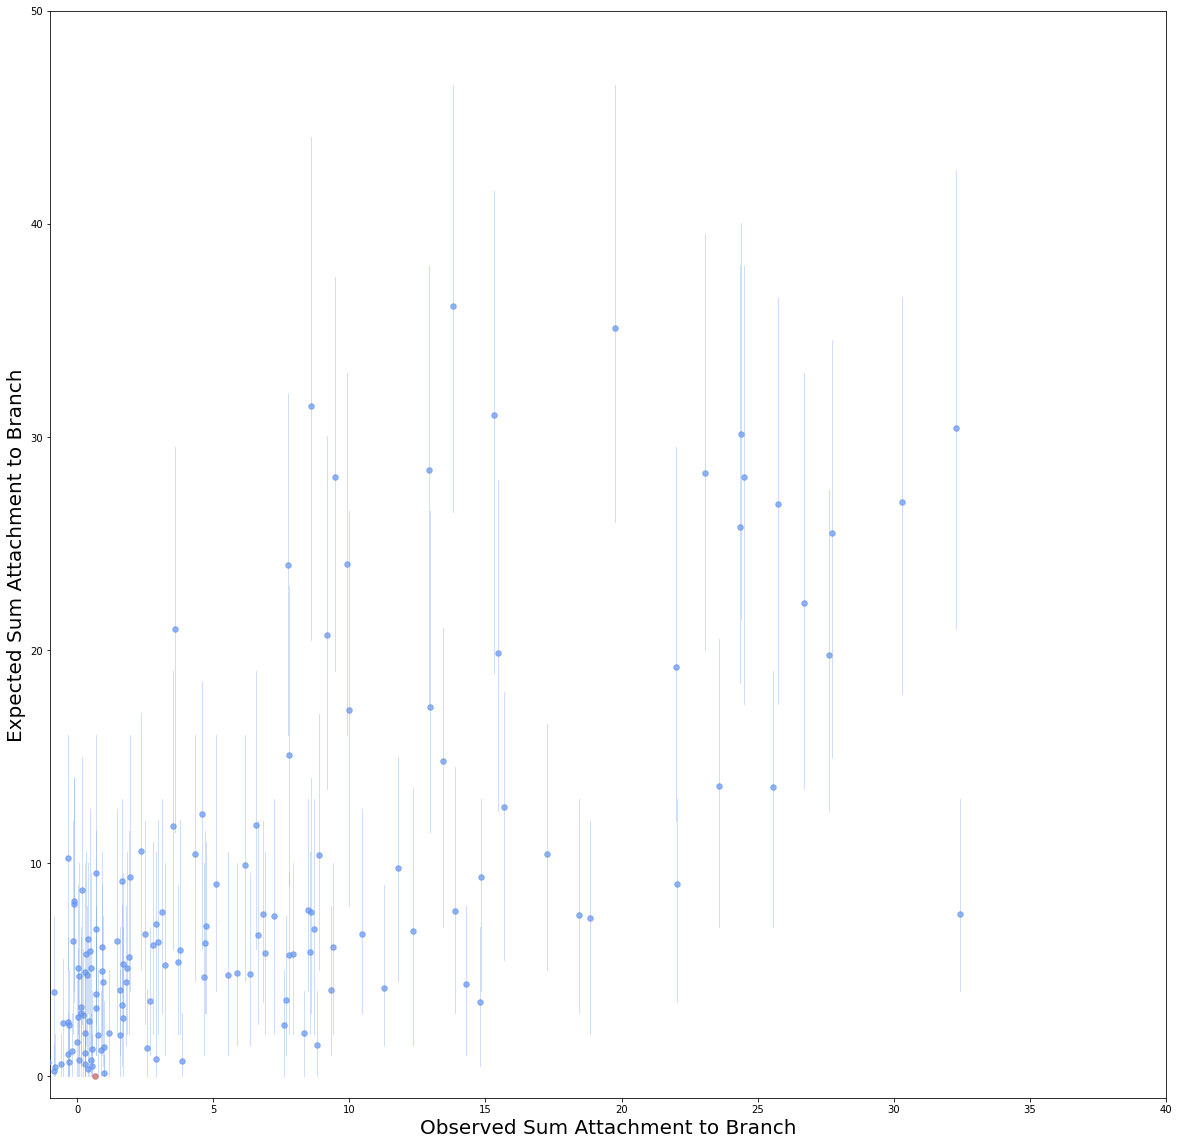

In [24]:
#the summed number of dropped observations expected to fall on each edge (with 2.5th and 97.5th percentiles)
#plotted against that actual observed number of dropped samples attached to each branch
exp_sum_att = list(sum(exp)) #column sums
obs_sum_att = list(sum(obs)) #column sums

def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

obs_sum_att = rand_jitter(obs_sum_att)

fig,ax = plt.subplots(figsize=(20,20),facecolor='w')
for cur_exp, cur_obs, lb, ub in zip(exp_sum_att, obs_sum_att, pct_025, pct_975):
    if lb < cur_exp and cur_exp < ub:
        c = 'cornflowerblue'
        orde = 10
    else:
        c= 'indianred'
        orde = 20
    ax.scatter(cur_obs,cur_exp,s=30,facecolor=c,edgecolor=c, alpha = .7, zorder = orde)
    ax.plot([cur_obs,cur_obs],[lb, ub],lw=1, color=c,ls='-', alpha = .3, zorder = orde) 

ax.set_xlabel('Observed Sum Attachment to Branch', fontsize = 20)
ax.set_ylabel('Expected Sum Attachment to Branch', fontsize = 20)
ax.set_ylim(-1, 50) 
ax.set_xlim(-1, 40) 
plt.show()

In [21]:
pearsonr(exp_sum_att, obs_sum_att)

(0.67797689597658461, 9.6329772767048208e-23)